In [18]:
import pandas as pd
import numpy as np
from datetime import date
import json

import gspread
from google.cloud import bigquery
from google.oauth2.service_account import Credentials


# Inicializar o cliente do BigQuery
client = bigquery.Client()

# Define the scope for the Google Sheets API
scope = [
    'https://www.googleapis.com/auth/spreadsheets',
    'https://www.googleapis.com/auth/drive',
]

# Create a credentials instance from a service account file
import google.auth
creds, project = google.auth.default(scopes=scope)

# Open the Google Spreadsheet
gc = gspread.authorize(creds)
spreadsheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1wGIbM4LR33xFlNOJrr7-nc0RZBf7JmP_c9UwWq_kr_o/edit?gid=0#gid=0')

In [19]:
import pandas as pd

# Lê os fatores
df_fatores = pd.read_csv('../inputs/Fatores.csv')
fatores = df_fatores['fator']

# Gera todas as combinações fator x fator
df_esqueleto = pd.merge(
    fatores.to_frame(name='fator_origem'), 
    fatores.to_frame(name='fator_destino'), 
    how='cross'
)
df_esqueleto['valor'] = ''
df_esqueleto.loc[df_esqueleto['fator_origem'] == df_esqueleto['fator_destino'], 'valor'] = '-'

# Cria a matriz pivotada, inicialmente vazia
matriz_fatores = df_esqueleto.pivot_table(
    index='fator_origem', 
    columns='fator_destino', 
    values='valor',  # ainda não existe, então resultará em NaN
    aggfunc='first'
)

# Opcional: converter NaN em strings vazias para facilitar o preenchimento
matriz_fatores = matriz_fatores.fillna("")

matriz_fatores

fator_destino,Acabamento Superficial do Grão e pureza da parafina,Disponibilidade de Tempo,Documentação de Projeto,Experiência da Equipe,Massa de Parafina,Orçamento Disponível,Qualidade da Comunicação,Razão de mistura O/F e controle de vazão do oxigênio,Sucesso do Lançamento,Temperatura Ambiente,Temperatura do Oxigênio,Volume da Câmara
fator_origem,,,,,,,,,,,,
Acabamento Superficial do Grão e pureza da parafina,-,,,,,,,,,,,
Disponibilidade de Tempo,,-,,,,,,,,,,
Documentação de Projeto,,,-,,,,,,,,,
Experiência da Equipe,,,,-,,,,,,,,
Massa de Parafina,,,,,-,,,,,,,
Orçamento Disponível,,,,,,-,,,,,,
Qualidade da Comunicação,,,,,,,-,,,,,
Razão de mistura O/F e controle de vazão do oxigênio,,,,,,,,-,,,,
Sucesso do Lançamento,,,,,,,,,-,,,


In [20]:
# send data to sheets
path = '../llm_results_cache.json'

json_log_file = json.load(open(path, 'r'))

ultima_atualizacao = json_log_file.get("timestamp", "")


matrizes_rodadas = []

for round_data in json_log_file['rounds']:
    # print(round_data)
    descript = round_data.get("description", "")
    
    matrix = round_data.get("matrix", [])
    matrizes_rodadas.append(matrix)
    
    justifications = round_data.get("justifications", {})
    
    df_matrix = matriz_fatores.copy()

    for justification_key, justification_value in justifications.items():
        causa, consequencia = justification_key.split("->")
        df_matrix.loc[causa, consequencia] = justification_value
        # print(f"{justification_key}: {justification_value}")
    
    worksheet = spreadsheet.worksheet(f"Rodada {round_data['round_number'] + 1}")
    df_matrix.fillna('', inplace=True)
    df_matrix = df_matrix.reset_index()

    data_with_headers = [df_matrix.columns.values.tolist()] + df_matrix.values.tolist()

    worksheet.clear()
    worksheet.update(range_name='A2', values=data_with_headers)
    worksheet.update_acell('A1', f'Última atualização em {ultima_atualizacao}')


matrizes_rodadas

[[[0.0, 4.0, 7.0, 0.0, 0.0, 4.0, 5.0, 2.0, 3.0, 4.0, 0.0, 7.0],
  [0.0, 0.0, 7.0, 3.0, 0.0, 6.0, 7.0, 3.0, 5.0, 6.0, 0.0, 8.0],
  [0.0, 6.0, 0.0, 5.0, 0.0, 4.0, 0.0, 0.0, 0.0, 4.0, 0.0, 7.0],
  [0.0, 4.0, 6.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 4.0, 0.0, 7.0],
  [0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 6.0, 3.0, 6.0, 6.0, 0.0, 7.0],
  [0.0, 2.0, 0.0, 2.0, 0.0, 0.0, 6.0, 0.0, 7.0, 0.0, 0.0, 7.0],
  [0.0, 2.0, 0.0, 0.0, 0.0, 5.0, 0.0, 2.0, 4.0, 2.0, 0.0, 8.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 2.0, 2.0, 0.0, 7.0],
  [0.0, 2.0, 0.0, 0.0, 0.0, 2.0, 6.0, 0.0, 0.0, 3.0, 0.0, 7.0],
  [0.0, 2.0, 0.0, 2.0, 0.0, 0.0, 4.0, 2.0, 2.0, 0.0, 0.0, 6.0],
  [0.0, 0.0, 2.0, 2.0, 0.0, 2.0, 4.0, 3.0, 2.0, 4.0, 0.0, 4.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],
 [[0.0, 4.0, 7.0, 0.0, 0.0, 5.0, 6.0, 3.0, 5.0, 3.0, 0.0, 7.0],
  [0.0, 0.0, 7.0, 3.0, 0.0, 5.0, 7.0, 4.0, 5.0, 6.0, 0.0, 8.0],
  [0.0, 6.0, 0.0, 5.0, 0.0, 3.0, 0.0, 0.0, 0.0, 4.0, 0.0, 7.0],
  [0.0, 4.0, 6.0, 0.0, 0.0, 3.0, 0.0, 0

In [ ]:
import textwrap
import itertools
from networkx.algorithms.cycles import find_cycle
import numpy as np
import networkx as nx

# ---------- PASSO 2: normalização (M) e matriz de relação total (T) -----
def _dematel(A, verbose=False) -> None:
    
    n = A.shape[0]
    
    row_sums = A.sum(axis=1)
    col_sums = A.sum(axis=0)
    k = min(1/row_sums.max(), 1/col_sums.max())
    M = A * k
    T = M @ np.linalg.inv(np.eye(n) - M)
    R = T.sum(axis=1)            # influência exercida
    C = T.sum(axis=0)            # influência recebida
    rc_diff = R - C
    rc_sum = R + C
    
    if verbose:
        df_print = pd.DataFrame(
            data = {
                "Fator": fatores, 
                "R-C":rc_diff, 
                "R+C":rc_sum
                }
        )
        print(df_print.to_markdown(index=False))

    return T

# __________ Gráfico DEMATEL __________
def plot_influence_diagram(T, factors, title="Diagrama de influências DEMATEL", verbose=False):
    """
    Cria um gráfico de dispersão DEMATEL melhorado usando matplotlib.
    x: R + C (importância/prominence)
    y: R - C (efeito líquido)
    
    Melhorias implementadas:
    - Quadrantes coloridos indicando zonas de causalidade
    - Tamanhos de pontos proporcionais à importância
    - Cores diferenciadas por quadrante
    - Algoritmo anti-sobreposição de rótulos melhorado
    - Legenda explicativa dos quadrantes
    - Visual mais profissional
    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from adjustText import adjust_text
    
    # Calculando parâmetros
    R = T.sum(axis=1)  # influência exercida
    C = T.sum(axis=0)  # influência recebida
    rc_sum = R + C     # Prominence (importância)
    rc_diff = R - C    # Net effect (efeito líquido)

    x = rc_sum
    y = rc_diff
    
    # Tamanhos proporcionais à importância (R+C)
    min_size, max_size = 100, 800
    sizes = ((x - x.min()) / (x.max() - x.min() + 1e-9)) * (max_size - min_size) + min_size

    # Função para quebrar o texto de forma mais compacta
    def _wrap(label, width=12):
        label = ' '.join(label.split())
        if len(label) <= width:
            return label
        # Tentar quebrar em palavras importantes primeiro
        words = label.split()
        if len(words) <= 2:
            return label
        # Para textos longos, quebrar mais agressivamente
        return '\n'.join(textwrap.wrap(label, width=width))

    wrapped_factors = [_wrap(f, width=15) for f in factors]

    # Criação do gráfico com melhor estilo e mais espaço
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(16, 12))
    
    # Definir limites para os quadrantes com mais espaço para rótulos
    x_min, x_max = x.min() * 0.85, x.max() * 1.15
    y_min, y_max = y.min() * 1.3, y.max() * 1.3
    
    # Criar quadrantes coloridos de fundo
    # Quadrante superior direito: Fatores causais importantes
    rect1 = patches.Rectangle((x.mean(), 0), x_max - x.mean(), y_max, 
                             linewidth=0, facecolor='#FFE6E6', alpha=0.3, zorder=0)
    # Quadrante superior esquerdo: Fatores causais menos importantes  
    rect2 = patches.Rectangle((x_min, 0), x.mean() - x_min, y_max, 
                             linewidth=0, facecolor='#FFF0E6', alpha=0.3, zorder=0)
    # Quadrante inferior direito: Fatores de efeito importantes
    rect3 = patches.Rectangle((x.mean(), y_min), x_max - x.mean(), -y_min, 
                             linewidth=0, facecolor='#E6F3FF', alpha=0.3, zorder=0)
    # Quadrante inferior esquerdo: Fatores de efeito menos importantes
    rect4 = patches.Rectangle((x_min, y_min), x.mean() - x_min, -y_min, 
                             linewidth=0, facecolor='#F0F0F0', alpha=0.3, zorder=0)
    
    ax.add_patch(rect1)
    ax.add_patch(rect2) 
    ax.add_patch(rect3)
    ax.add_patch(rect4)

    # Cores dos pontos baseadas nos quadrantes
    colors = []
    for xi, yi in zip(x, y):
        if yi > 0:  # Causas
            if xi > x.mean():
                colors.append('#D32F2F')  # Vermelho escuro - Causas importantes
            else:
                colors.append('#FF5722')  # Laranja - Causas menos importantes
        else:  # Efeitos
            if xi > x.mean():
                colors.append('#1976D2')  # Azul escuro - Efeitos importantes
            else:
                colors.append('#757575')  # Cinza - Efeitos menos importantes

    # Scatter plot com pontos coloridos e tamanhos variados
    scatter = ax.scatter(x, y, s=sizes, c=colors, alpha=0.8, 
                        edgecolors='white', linewidth=2, zorder=3)

    # Linhas de referência
    ax.axhline(0, color='black', linewidth=2, alpha=0.7, zorder=1)
    ax.axvline(x.mean(), color='black', linewidth=1, linestyle='--', alpha=0.5, zorder=1)

    # Algoritmo simplificado para rótulos - posicionamento inteligente baseado na posição do ponto
    for i, (xi, yi, txt) in enumerate(zip(x, y, wrapped_factors)):
        # Determinar posição baseada no quadrante para evitar sobreposição
        if xi < x.mean():  # Lado esquerdo
            ha = 'right'
            offset_x = -12
        else:  # Lado direito
            ha = 'left' 
            offset_x = 12
            
        if yi > 0:  # Parte superior
            va = 'bottom'
            offset_y = 12
        else:  # Parte inferior
            va = 'top'
            offset_y = -12
        
        # Adicionar rótulo com posicionamento inteligente
        ax.annotate(
            txt,
            (xi, yi),
            xytext=(offset_x, offset_y),
            textcoords='offset points',
            fontsize=10,
            fontweight='bold',
            ha=ha,
            va=va,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.95, edgecolor='lightgray', linewidth=0.5),
            zorder=4
        )

    # Configurar eixos e labels
    ax.set_xlabel("R + C (Prominence - Importância)", fontsize=12, fontweight='bold')
    ax.set_ylabel("R - C (Relation - Efeito Líquido)", fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    
    # Definir limites
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Legenda dos quadrantes
    legend_elements = [
        patches.Patch(color='#D32F2F', alpha=0.8, label='Causas Importantes'),
        patches.Patch(color='#FF5722', alpha=0.8, label='Causas Secundárias'),
        patches.Patch(color='#1976D2', alpha=0.8, label='Efeitos Importantes'),
        patches.Patch(color='#757575', alpha=0.8, label='Efeitos Secundários')
    ]
    
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1), 
             frameon=True, fancybox=True, shadow=True)

    # Adicionar anotações dos quadrantes
    ax.text(x.mean() + (x_max - x.mean())/2, y_max * 0.9, 'CAUSAS\nIMPORTANTES', 
           ha='center', va='center', fontsize=10, fontweight='bold', 
           alpha=0.7, color='#D32F2F')
    ax.text(x_min + (x.mean() - x_min)/2, y_max * 0.9, 'CAUSAS\nSECUNDÁRIAS', 
           ha='center', va='center', fontsize=10, fontweight='bold', 
           alpha=0.7, color='#FF5722')
    ax.text(x.mean() + (x_max - x.mean())/2, y_min * 0.9, 'EFEITOS\nIMPORTANTES', 
           ha='center', va='center', fontsize=10, fontweight='bold', 
           alpha=0.7, color='#1976D2')
    ax.text(x_min + (x.mean() - x_min)/2, y_min * 0.9, 'EFEITOS\nSECUNDÁRIOS', 
           ha='center', va='center', fontsize=10, fontweight='bold', 
           alpha=0.7, color='#757575')

    # Grid sutil
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
    # Ajustar layout
    plt.tight_layout()
    
    if verbose:
        # Imprimir estatísticas dos fatores
        df_stats = pd.DataFrame({
            'Fator': factors,
            'R (Influência Exercida)': R.round(3),
            'C (Influência Recebida)': C.round(3),
            'R+C (Prominence)': rc_sum.round(3),
            'R-C (Relation)': rc_diff.round(3),
            'Quadrante': ['Causa Importante' if yi > 0 and xi > x.mean() else
                         'Causa Secundária' if yi > 0 and xi <= x.mean() else
                         'Efeito Importante' if yi <= 0 and xi > x.mean() else
                         'Efeito Secundário' for xi, yi in zip(x, y)]
        })
        print("\n" + "="*80)
        print("ANÁLISE DEMATEL - ESTATÍSTICAS DOS FATORES")
        print("="*80)
        print(df_stats.to_string(index=False))
        print("="*80)
    
    plt.show()

def ensure_dag(G):
    """
    Remove arestas até que o grafo fique acíclico (mantém as de maior peso).
    """
    G = G.copy()
    # Tenta usar nx.find_cycle; fallback para import direto se não existir
    try:
        find_cycle_func = nx.find_cycle
    except AttributeError:
        from networkx.algorithms.cycles import find_cycle as find_cycle_func

    while True:
        try:
            cycle_edges = find_cycle_func(G, orientation="original")
        except nx.exception.NetworkXNoCycle:
            break
        # remove a aresta de menor peso no ciclo
        min_edge = min(
            cycle_edges,
            key=lambda e: G.get_edge_data(e[0], e[1]).get("weight", 1)
        )
        G.remove_edge(*min_edge[:2])
    return G

def build_graph(
    T: np.ndarray,
    factors: list[str],
    threshold: float | None = None,
    include_weights: bool = True,
    enforce_dag: bool = False,
    numeric_filter: bool = False
 ) -> nx.DiGraph:
    """
    Constrói grafo dirigido a partir da matriz total DEMATEL T.

    Parâmetros
    ----------
    T : np.ndarray
        Matriz de relação total (n x n).
    factors : list[str]
        Nomes dos fatores (len == n).
    threshold : float | None
        Limite mínimo do peso (se None usa média de T).
    include_weights : bool
        Se True armazena pesos reais; senão usa peso = 1.
    enforce_dag : bool
        Se True remove ciclos.
    numeric_filter : bool
        Aplica filtro adicional usando mediana de rc_sum e (μ + 0.5σ) de T.

    Retorna
    -------
    nx.DiGraph
        Grafo de influências filtrado.
    """
    R = T.sum(axis=1)            # influência exercida
    C = T.sum(axis=0)            # influência recebida
    rc_diff = R - C
    rc_sum = R + C
    
    n = len(factors)
    if threshold is None:
        threshold = T.mean()

    if numeric_filter:
        prom_threshold = np.percentile(rc_sum, 50)
        edge_threshold = T.mean() + 0.5 * T.std()
    else:
        prom_threshold = edge_threshold = None

    G = nx.DiGraph()
    G.add_nodes_from(factors)

    for i, j in itertools.product(range(n), repeat=2):
        if i == j:
            continue
        w_val = T[i, j]
        if w_val <= threshold:
            continue
        if numeric_filter:
            if not (rc_sum[i] > prom_threshold and w_val > edge_threshold):
                continue
        w = round(w_val, 3) if include_weights else 1
        G.add_edge(factors[i], factors[j], weight=w)

    if enforce_dag:
        print("Enforcing DAG...")
        G = ensure_dag(G)

    return G

# --------- Graphviz-based hierarchical plot: plot_network ---------
def plot_network(
    G: nx.DiGraph,
    T: np.ndarray,
    node_size_scale: float = 50.0,
    edge_width_scale: float = 3.0,
    title: str | None = None,
    hierarchical: bool = True,
    layer_gap: float = 0.28,
    wrap_chars: int = 18,
 ):
    """
    Alternativa com **Graphviz** para gerar um DAG legível:
      • Layout em camadas verticais (rankdir=TB), causas acima dos efeitos
      • Caixas com quebra de linha; sem sobreposição (overlap=false, nodesep/ranksep)
      • Arestas ortogonais roteadas por fora das caixas (splines=ortho)
      • Bidirecionais como duas arestas separadas

    Dependências: `pip install graphviz` e o binário do Graphviz instalado no sistema
    (ex.: `brew install graphviz` no macOS, `apt-get install graphviz` no Linux, ou o
    instalador oficial no Windows).
    """
    try:
        import graphviz
    except Exception as e:
        raise ImportError(
            "A biblioteca 'graphviz' não está disponível. Instale com 'pip install graphviz' e certifique-se de ter o Graphviz instalado no sistema."
        ) from e

    # ------- helpers (iguais em espírito ao plot_graph2) -------
    def _levels_dag(graph: nx.DiGraph) -> dict:
        H = graph.copy()
        try:
            _ = list(nx.topological_sort(H))
        except nx.NetworkXUnfeasible:
            H = ensure_dag(H)
        roots = [n for n, d in H.in_degree() if d == 0] or list(H.nodes())
        level = {r: 0 for r in roots}
        for u in nx.topological_sort(H):
            for v in H.successors(u):
                level[v] = max(level.get(v, 0), level[u] + 1)
        return level

    def _wrap(label: str, width: int) -> str:
        clean = ' '.join(str(label).split())
        if len(clean) <= width:
            return clean
        return "\n".join(textwrap.wrap(clean, width=width))

    # --------- níveis e grupos por rank ---------
    level = _levels_dag(G)
    max_level = max(level.values()) if level else 0
    nodes_by_lvl = {l: [n for n, lv in level.items() if lv == l] for l in range(max_level + 1)}

    # --------- prepara rótulos e pesos ---------
    rc_sum = T.sum(axis=1) + T.sum(axis=0)
    rc_diff = T.sum(axis=1) - T.sum(axis=0)

    # --------- cria o grafo Graphviz ---------
    ranksep = max(0.5, layer_gap * 2.8)  # separação vertical entre níveis
    dot = graphviz.Digraph(format="svg", engine="dot")
    dot.attr(
        rankdir="TB",
        splines="ortho",
        overlap="false",
        nodesep="0.45",
        ranksep=str(ranksep),
        pad="0.2",
        bgcolor="#f7f9fc",
        label=(title or "Topologia DEMATEL-LLM (DAG)"),
        labelloc="t",
        fontsize="18",
        fontname="Arial",
    )
    dot.node_attr.update(
        shape="box",
        style="rounded,filled",
        fillcolor="#3498DB",
        color="#3c3c3c",
        fontcolor="white",
        penwidth="1.5",
        margin="0.1,0.06",
        fontname="Arial",
    )
    dot.edge_attr.update(
        color="black",
        arrowsize="0.8",
        penwidth="1.2",
    )

    # Para estabilidade, damos um id interno seguro para cada nó
    node_ids = {name: f"n{idx}" for idx, name in enumerate(G.nodes())}

    # --- adiciona nós, agrupando por nível com rank=same ---
    for l in range(max_level + 1):
        with dot.subgraph(name=f"rank_{l}") as s:
            s.attr(rank="same")
            for n in nodes_by_lvl.get(l, []):
                label = _wrap(n, wrap_chars)
                # opcional: destacar causas (nível 0) com cor diferente
                attrs = {}
                if l == 0:
                    attrs["fillcolor"] = "#2E86C1"
                s.node(node_ids[n], label=label, **attrs)

    # --- adiciona arestas com espessura proporcional ao peso ---
    for u, v, d in G.edges(data=True):
        w = float(d.get("weight", 1))
        pen = max(1.0, w * edge_width_scale * 0.6)
        # força distância vertical coerente ao pular níveis
        lvl_diff = max(1, level.get(v, 0) - level.get(u, 0))
        dot.edge(node_ids[u], node_ids[v], penwidth=str(pen), minlen=str(lvl_diff))

    # Tenta exibir inline (Jupyter) e também retorna o objeto
    try:
        from IPython.display import display, SVG
        svg = dot.pipe(format="svg")
        display(SVG(svg))
    except Exception:
        # fallback: apenas retorna/printa o DOT
        print(dot.source)

    # return dot


Enforcing DAG...
G: 12 nodes, 14 edges


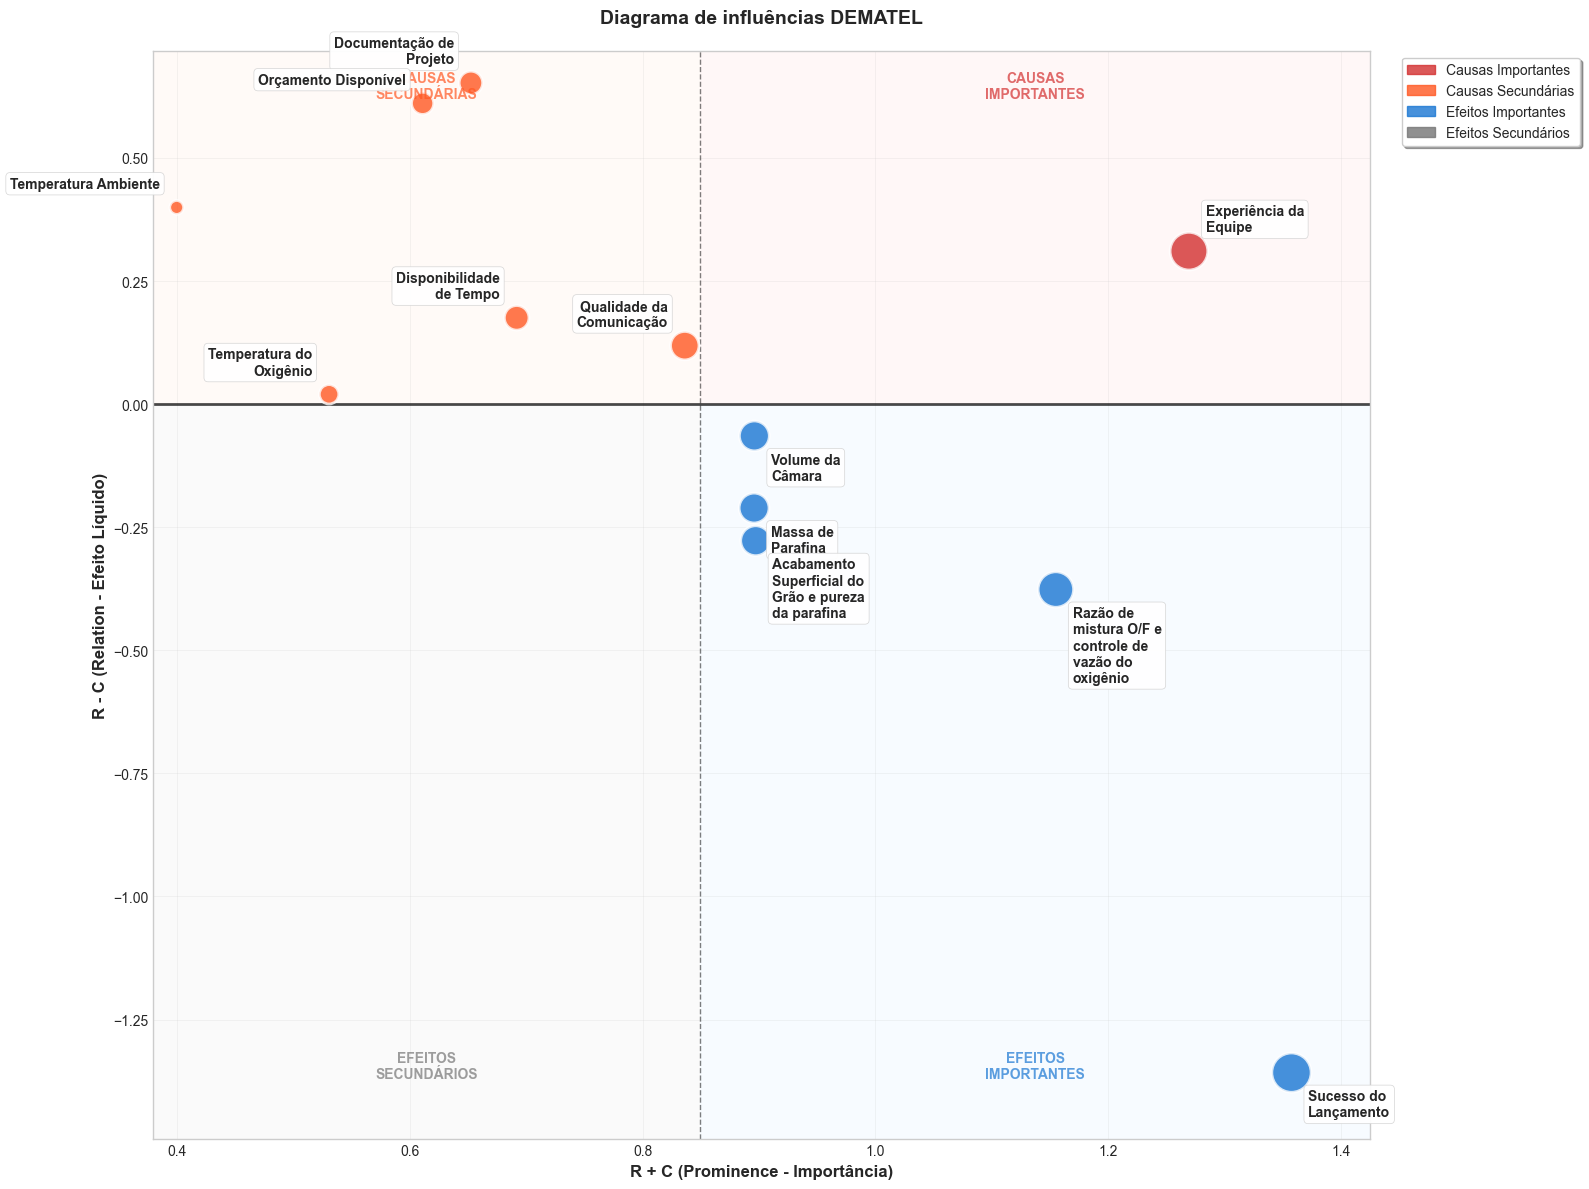

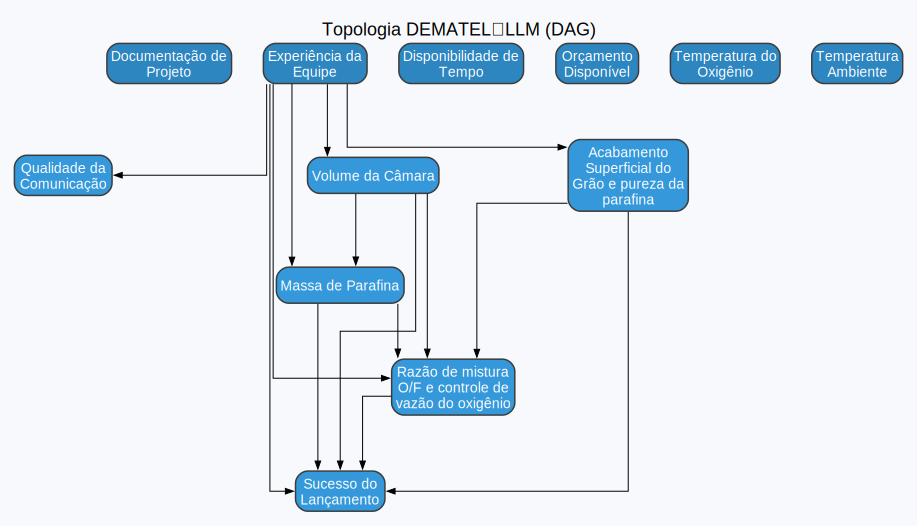

Enforcing DAG...
G: 12 nodes, 14 edges


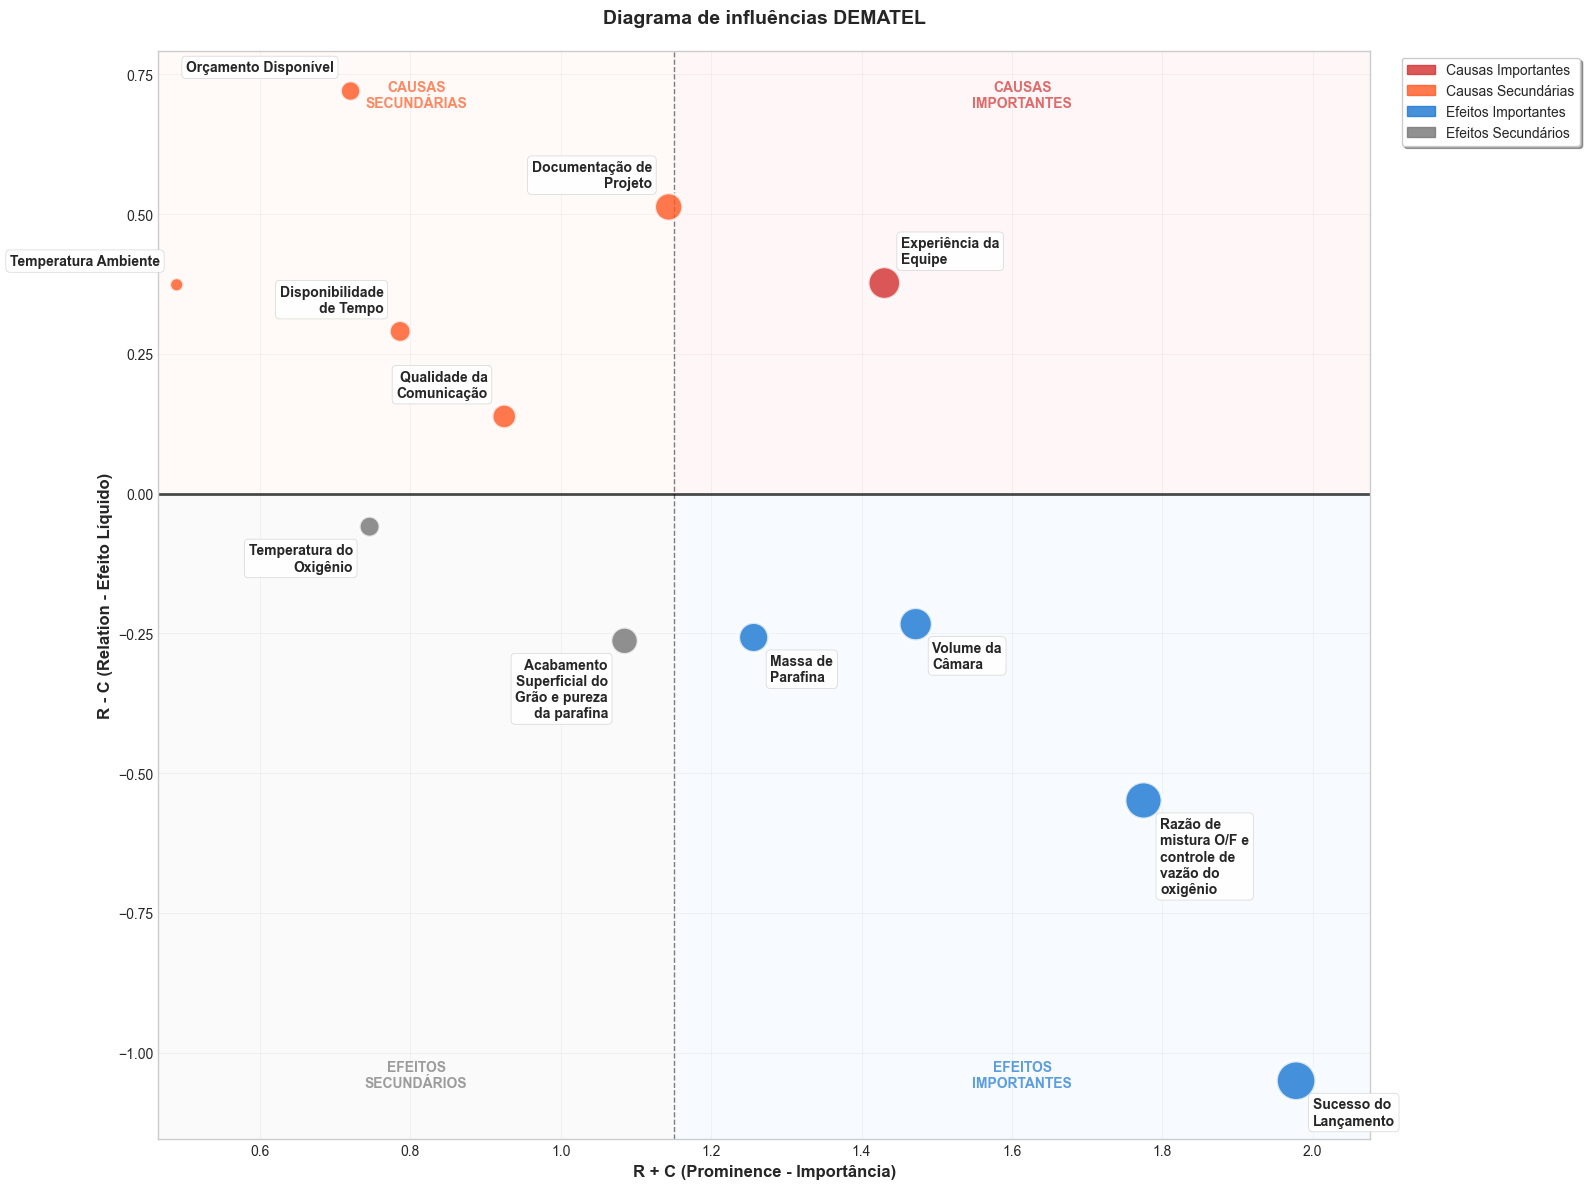

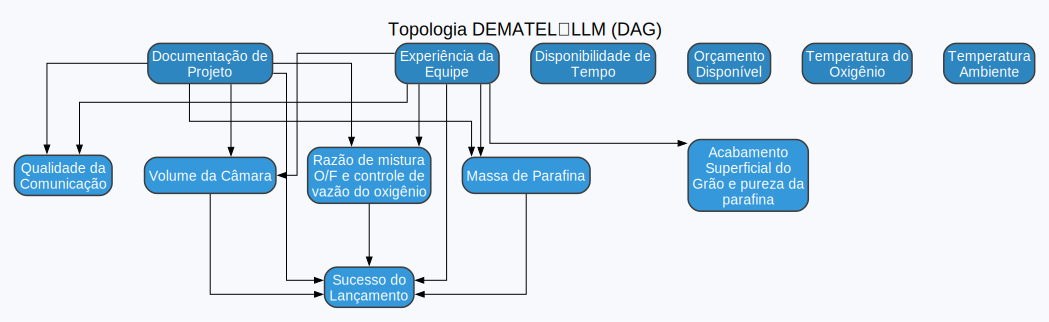

Enforcing DAG...
G: 12 nodes, 17 edges


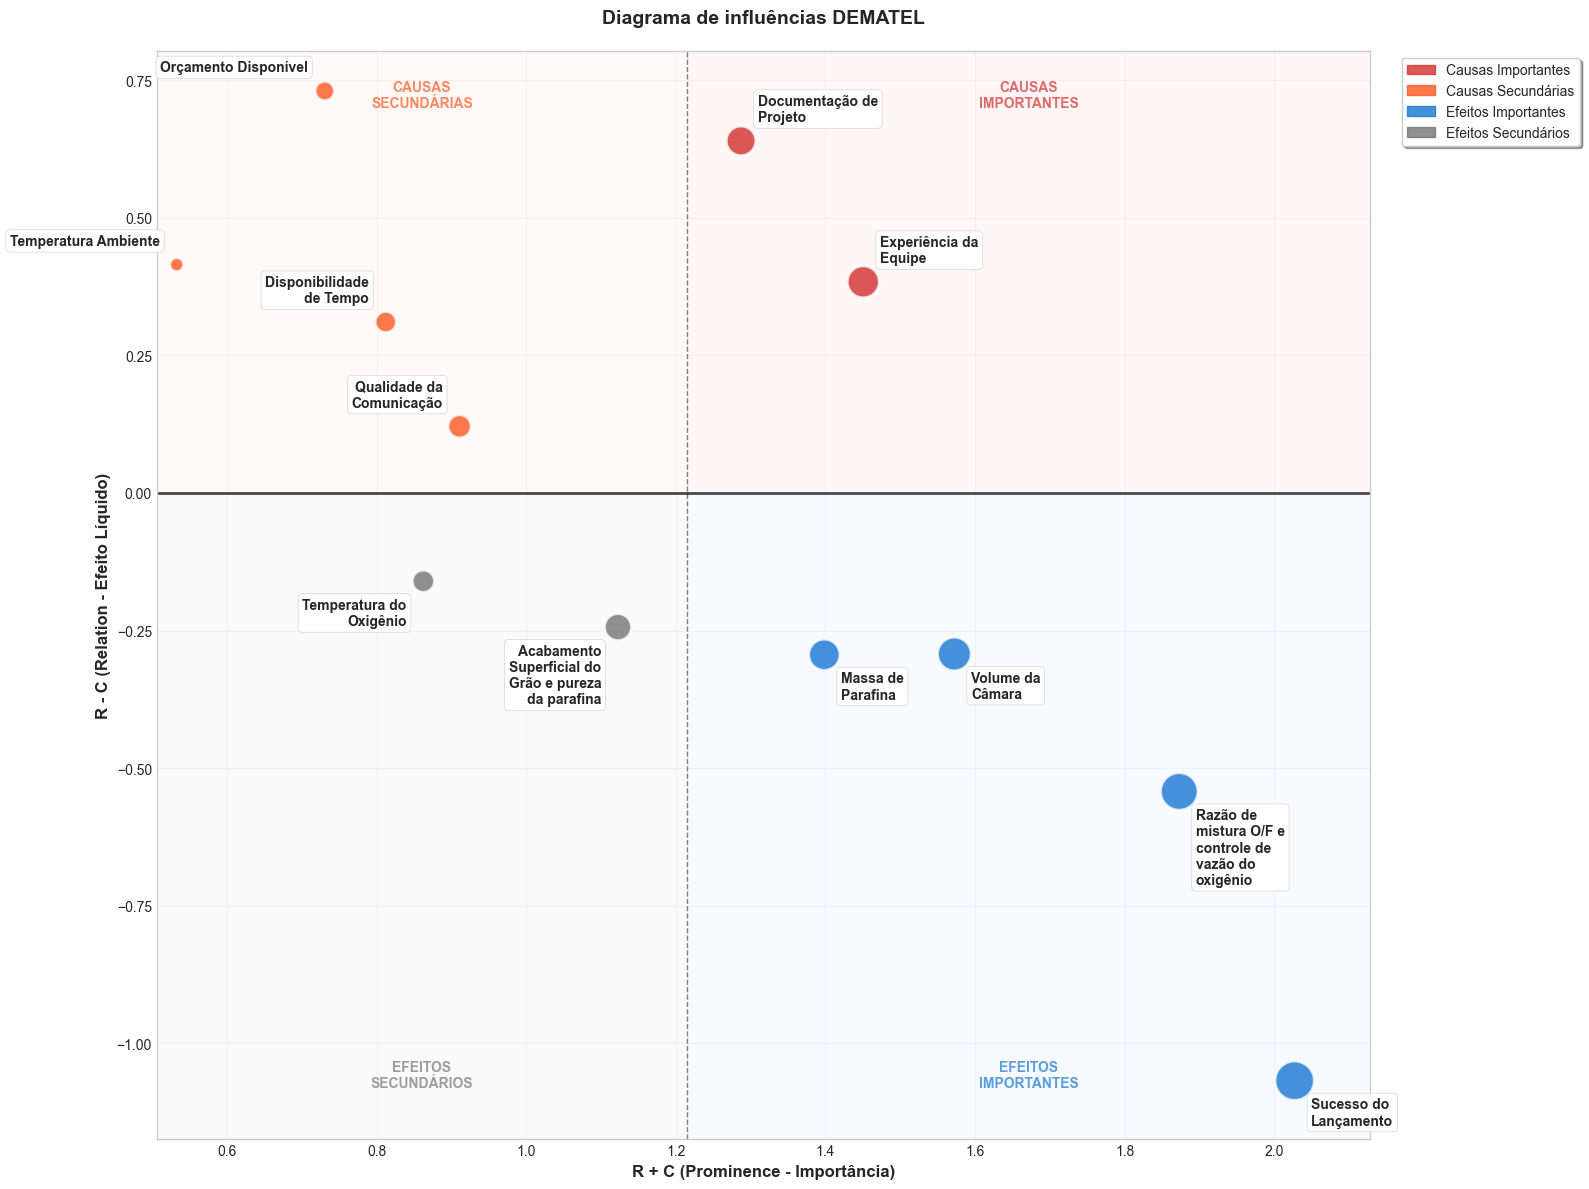

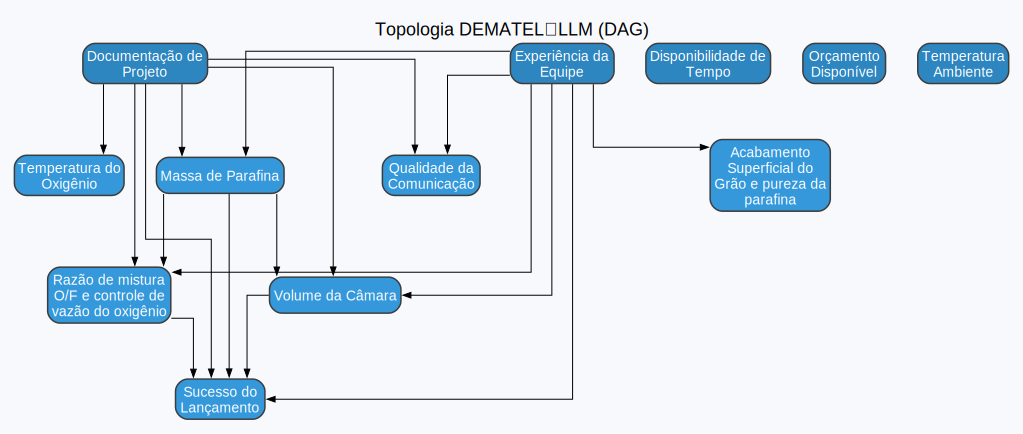

In [24]:
for matriz in matrizes_rodadas:
    print("="*80)
    matriz = np.array(matriz)
    T = _dematel(matriz)
    G = build_graph(
        T,
        fatores,
        threshold=None,
        include_weights=True,
        enforce_dag=True,
        numeric_filter=True
    )
    print(f"G: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    

    plot_influence_diagram(
        T,
        fatores,
        title="Diagrama de influências DEMATEL",
        verbose=False
    )

    plot_network(
        G,
        T,
        node_size_scale=50.0,
        edge_width_scale=3.0,
        title="Topologia DEMATEL‑LLM (DAG)",
        hierarchical=True,
        layer_gap=0.28,
        wrap_chars=18,
    )
    print("="*80)